# Structural Concrete Strength Prediction Model with 85% Accuracy 

In [67]:
#Main Library Imports 
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
%matplotlib inline

# Sourced Dataset From Kaggle 

In [68]:
#import data and show first 5 rows *units are kg/m^3, days, and MPa*
concCompStrength = pd.read_csv('concCompStrength.csv')
#rename the columns to access them easier 
concCompStrength.columns = ['cement','slag','fly ash','water','superplasticizer','coarse agg','fine agg','age','strength']
#add a column for W/C ratio 
concCompStrength.insert(7,'wc ratio',concCompStrength['water'] / concCompStrength['cement'])
concCompStrength.head()

,cement,slag,fly ash,water,superplasticizer,coarse agg,fine agg,wc ratio,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,0.300000,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,0.300000,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,0.685714,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,0.685714,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,0.966767,360,44.296075


I added one new column to the data based on my experience with concrete mix design. Often the ratio of water to cement is a better indicator of the strength compared with just water content or cement content alone. 

# Explore The Data 

In [69]:
#number of rows and columns
originalRows = concCompStrength.shape[0]
concCompStrength.shape

(1030, 10)

We have 1030 concrete mix samples and 9 variables to predict the strength

In [70]:
#check if any values are null
concCompStrength.isnull().any()

cement              False
slag                False
fly ash             False
water               False
superplasticizer    False
coarse agg          False
fine agg            False
wc ratio            False
age                 False
strength            False
dtype: bool

None of the values are missing which is good

In [71]:
#check the descriptive statistics
concCompStrength.describe()

,cement,slag,fly ash,water,superplasticizer,coarse agg,fine agg,wc ratio,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,0.748269,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,0.314005,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,0.266893,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,0.533333,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,0.675349,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,0.935014,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,1.882353,365.000000,82.599225


I noticed that the minimum age here is 1 day which is not nearly enough for structural concrete to gain its full strength. 
"Concrete gains 16% strength in one day, 40% in 3 days, 65% in 7 days, 90% in 14 days, and 99% strength in 28 days" (from theconstructor.org). Based on this I decided to remove all samples with strength measured before 28 days.

In [72]:
#remove rows with age less than 28 days 
concCompStrength = concCompStrength.drop(concCompStrength[concCompStrength.age < 28].index)
concCompStrength.head(10)

,cement,slag,fly ash,water,superplasticizer,coarse agg,fine agg,wc ratio,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,0.300000,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,0.300000,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,0.685714,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,0.685714,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,0.966767,360,44.296075
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,0.857143,90,47.029847
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,0.600000,365,43.698299
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,0.600000,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,0.857143,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,0.480000,28,39.289790


In [7]:
#check the descriptive statistics
concCompStrength.describe()

,cement,slag,fly ash,water,superplasticizer,coarse agg,fine agg,wc ratio,age,strength
count,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000,706.000000
mean,277.086289,77.065142,57.355878,182.966048,6.538882,965.468966,768.191941,0.766667,63.566572,41.451923
std,104.512753,85.245005,64.936032,22.099107,5.816650,78.724837,80.900234,0.318832,69.256102,15.352923
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,0.266893,28.000000,8.535713
25%,183.925000,0.000000,0.000000,167.000000,0.000000,923.000000,712.925000,0.547801,28.000000,31.131565
50%,269.400000,38.000000,0.000000,185.000000,7.000000,965.700000,777.500000,0.689531,28.000000,39.586265
75%,342.000000,145.000000,118.270000,193.675000,10.300000,1022.950000,821.000000,0.966767,90.000000,51.831014
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,1.882353,365.000000,82.599225


When I removed the mixes with age less than 28 days, this got rid of 324 samples. The min strength is now a bit more reasonable and the variation in the overall strength is lower 

# Exploratory Data Analysis 

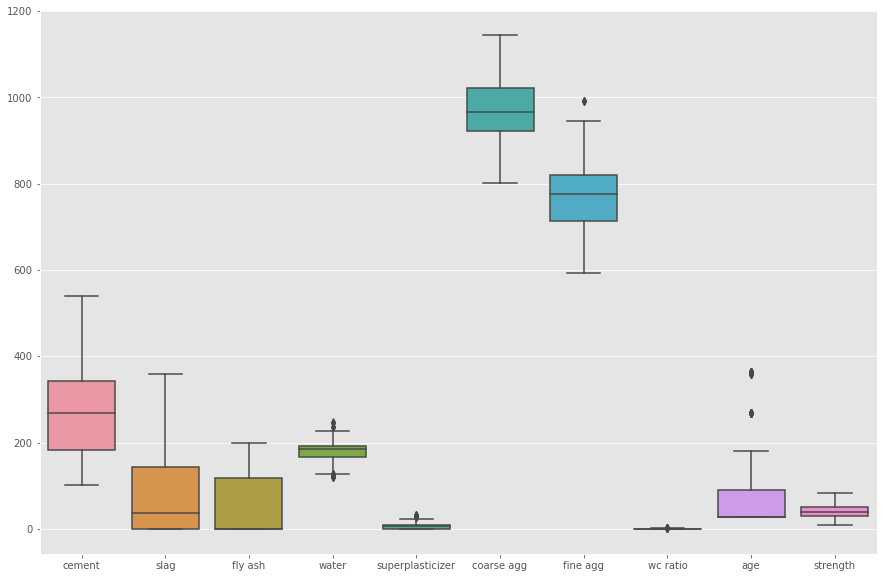

In [8]:
#create boxplot to visualize outliers
plt.figure(figsize = (15,10))
box = sns.boxplot(data=concCompStrength)

The water, superplasricizer, fine aggregate, wc ratio, and age variables all contain some outliers so I decided to remove those outliers with values of 3 standard deviations away from the mean.

In [76]:
#remove outliers defined as values greater than 3 STD from the mean
z_scores = stats.zscore(concCompStrength) #z-score = (value-mean)/STD

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
concCompStrength = concCompStrength[filtered_entries]

concCompStrength.head(10)

,cement,slag,fly ash,water,superplasticizer,coarse agg,fine agg,wc ratio,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,0.300000,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,0.300000,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,0.685714,270,40.269535
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,0.857143,90,47.029847
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,0.600000,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,0.857143,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,0.480000,28,39.289790
10,198.6,132.4,0.0,192.0,0.0,978.4,825.5,0.966767,90,38.074244
11,198.6,132.4,0.0,192.0,0.0,978.4,825.5,0.966767,28,28.021684
12,427.5,47.5,0.0,228.0,0.0,932.0,594.0,0.533333,270,43.012960


In [77]:
#check the descriptive statistics
concCompStrength.describe()

,cement,slag,fly ash,water,superplasticizer,coarse agg,fine agg,wc ratio,age,strength
count,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000,674.000000
mean,275.457151,76.323131,60.079006,182.434466,6.580491,967.033071,767.937552,0.764913,54.845697,41.332456
std,102.935839,84.427365,65.217626,21.479731,5.362993,79.478292,79.088079,0.309000,47.528735,15.431512
min,116.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,0.279693,28.000000,8.535713
25%,182.040000,0.000000,0.000000,166.632500,0.000000,923.000000,716.100000,0.547801,28.000000,31.024352
50%,266.000000,32.000000,0.000000,184.000000,7.000000,967.000000,776.350000,0.689531,28.000000,39.436648
75%,339.000000,145.000000,118.900000,193.000000,10.300000,1026.200000,816.600000,0.966767,56.000000,51.409054
max,540.000000,316.100000,200.100000,247.000000,23.400000,1145.000000,992.600000,1.694345,270.000000,82.599225


Remiving outliers got rid of 32 samples. However, most of the descriptive statistics for strength remain the same. Also, some rows with very high age were removed. This is okay because an older concrete will not be as representative of its original strength. 

Counter({'Normal': 657, 'Weak': 17})


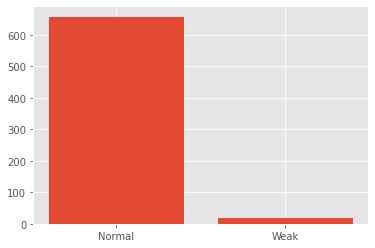

In [78]:
#define the weak mixes are less than 15MPa strength (usually these are for non-structural purposes)
#is there any feature that makes a mix weaker? 
weakVal = 15
weakMixes = concCompStrength[concCompStrength.strength < weakVal]
normalMixes = concCompStrength[concCompStrength.strength >= weakVal]
weakOrNorm = np.where(concCompStrength.strength < weakVal,'Weak','Normal')
from collections import Counter
counts = Counter(weakOrNorm)
plt.bar(counts.keys(),counts.values())
print(counts)

At this point I was concerned with the minimum strength of the samples being only 8 MPa. Structural Concrete typically has a strength greater than 15MPa and anything less that that is mainly used as backfill or for purposes where the strength is not so important. In this dataset there are 17 weak mixes with strength less than 15 MPa. 

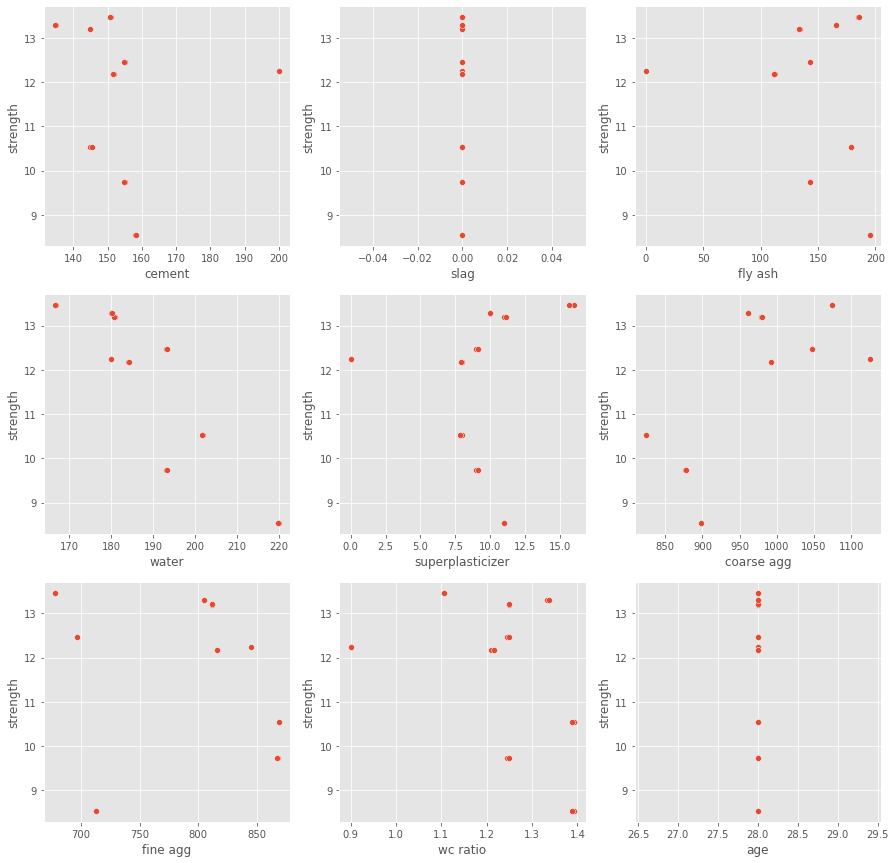

In [12]:
#visualize all weak mix data versus strength
plt.figure(figsize = (15, 15))
for idx,col in enumerate(weakMixes.columns,start=1):
    if idx>9:
        break
    plt.subplot(3,3,idx)
    sns.scatterplot(data=weakMixes, x=col, y="strength")

It is clear that all the weak mixes have no slag content. Although 15 samples is not really enough to make any conclusion from this, it is still an interesting find that could be investigated with more data. Another note to make here is that the w/c ratio are all greater than 1 except for one sample. This is expected since having more water than cement typically weakens a mix.

Text(0.5, 1.0, 'Weak Mixes (<15MPa)')

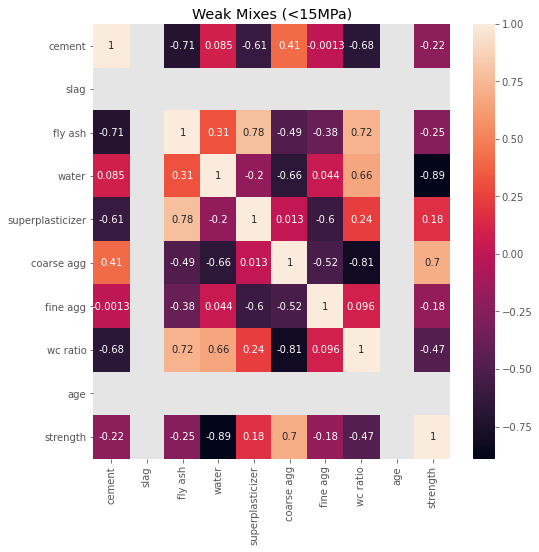

In [13]:
#Check the correlation of the weak mix variables
plt.figure(figsize = (8, 8))
sns.heatmap(weakMixes.corr(),annot=True).set_title(f'Weak Mixes (<{weakVal}MPa)')

The slag content and age do not show up here vbecuase their values do not change. Every weak mix has the same age ans same slag content. Also, water content has a high negative correlation. This means that more water = weaker mix. Coarse aggregate has a pretty high positive correlation meaning more coarse agg = stronger mix.

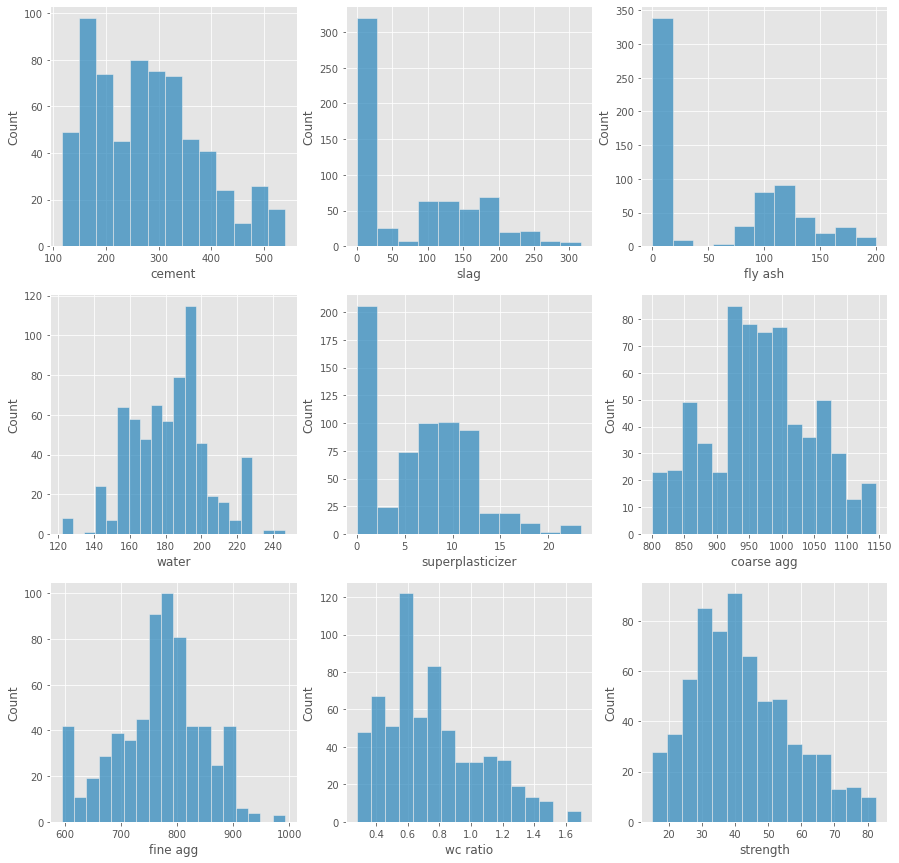

In [85]:
#visualize the distribution of the Normal Strength mixes 
plt.figure(figsize = (15, 15))
for idx,col in enumerate(normalMixes.columns,start=1):
    if idx==9:
        continue
    if idx==10:
        idx=9
    plt.subplot(3,3,idx)
    sns.histplot(data=normalMixes, x=col)

Note for the variables of slag, fly ash, and superplasticizer, we have a lot of mixes with a very small amount of them (i.e close to 0). In general, these components are the most expensive in concrete mixes and can be thought of as "add-ons" so it is reasonable that most mixes will not contain a lot of these components. I notice also that for fly ash there is not much data between 25-75 kg/m^3 and so I expect predictions for mixes wtih fly ash content in this range will not be very good.

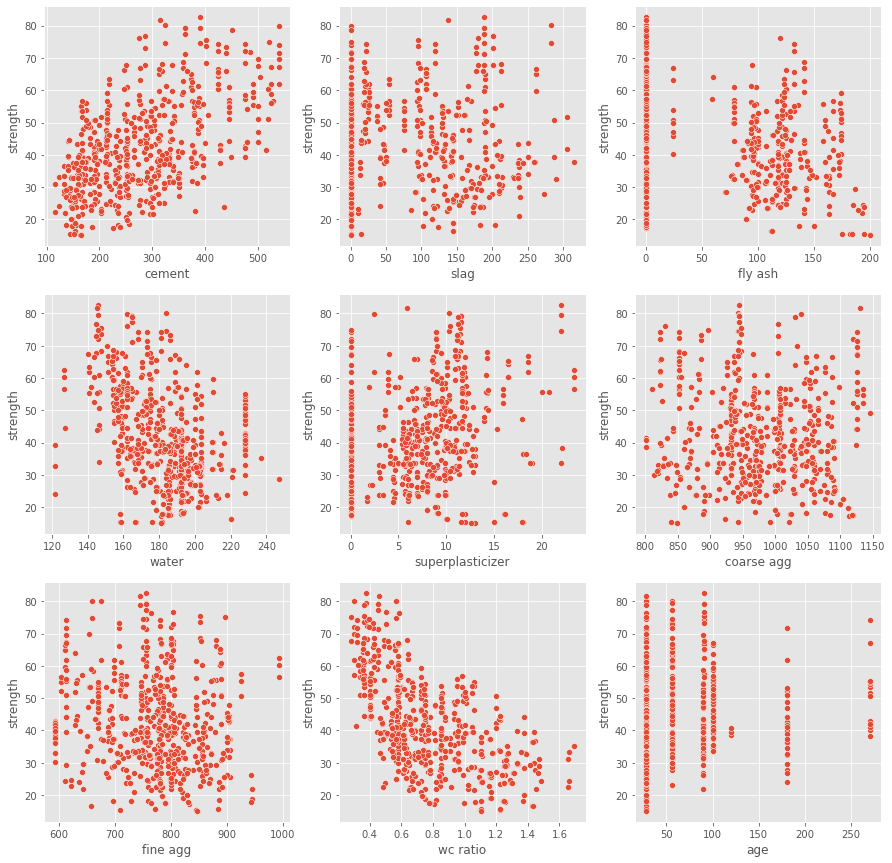

In [14]:
#visualize all normal mix data (strength > 15MPa) versus strength
plt.figure(figsize = (15, 15))
for idx,col in enumerate(normalMixes.columns,start=1):
    if idx>9:
        break
    plt.subplot(3,3,idx)
    sns.scatterplot(data=normalMixes, x=col, y="strength")

Text(0.5, 1.0, 'Normal Mixes (>15MPa)')

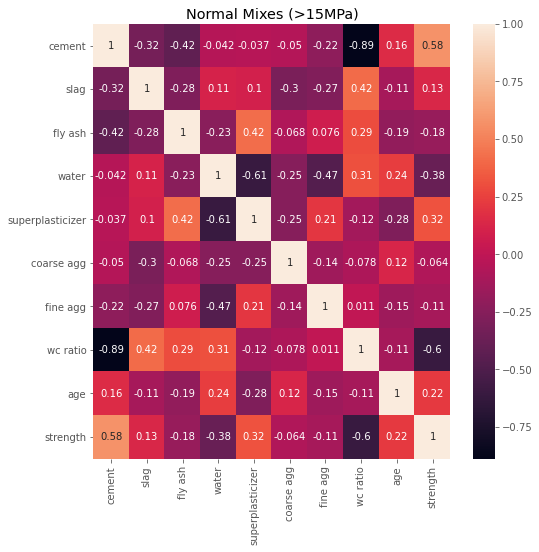

In [15]:
#Check the correlation of the normal mix variables
plt.figure(figsize = (8, 8))
sns.heatmap(normalMixes.corr(),annot=True).set_title(f'Normal Mixes (>{weakVal}MPa)')

In general, for normal strength mixes, the WC ratio is correlated most with the strength at -0.6. We can see here that the new variable of WC ratio is probably more useful than cement or water content alone. Coarse aggregate seems to be mostly irrelevant in normal mix strength. In weak mixes this was not the case.

# Setting up Numerical Model 

In [86]:
#normalize the data to use for ML algorithms 
#use standard scaler to make means of all distributions 0
from sklearn.preprocessing import StandardScaler
strength = normalMixes['strength']
variables = normalMixes.drop(columns='strength')

sc=StandardScaler()
scaledVars = sc.fit_transform(variables)
scaledVars = pd.DataFrame(scaledVars,columns=variables.columns)
scaledVars.head()

,cement,slag,fly ash,water,superplasticizer,coarse agg,fine agg,wc ratio,age
0,2.557049,-0.926170,-0.902853,-0.938548,-0.744043,0.921010,-1.155188,-1.498239,-0.574898
1,2.557049,-0.926170,-0.902853,-0.938548,-0.744043,1.110381,-1.155188,-1.498239,-0.574898
2,0.526941,0.759431,-0.902853,2.119854,-1.208866,-0.442461,-2.190729,-0.220718,4.476795
3,-0.123672,0.422311,-0.902853,2.119854,-1.208866,-0.442461,-1.230959,0.347070,0.719337
4,0.991665,0.197564,-0.902853,2.119854,-1.208866,-0.442461,-2.190729,-0.504611,-0.574898


In [18]:
#split the data into an 70/30 train/test set
from sklearn.model_selection import train_test_split
trainVars,testVars,trainStrength,testStrength=train_test_split(scaledVars,strength,test_size=.30,random_state=0)

In [19]:
#define the ML regression models to use 
from sklearn.linear_model import SGDRegressor,GammaRegressor,Lasso,GammaRegressor,ElasticNet,Ridge,LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
# Import model evaluation Tools 
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV 

lr=LinearRegression()
knn=KNeighborsRegressor()
rf=RandomForestRegressor()
dt=DecisionTreeRegressor()
lasso=Lasso()
sgd=SGDRegressor()
ridge=Ridge()
gboost=GradientBoostingRegressor()
bagging=BaggingRegressor()
adboost=AdaBoostRegressor()
etr=ExtraTreesRegressor()

# Train All The Models

In [20]:
#loop through the algortihms to train them all 
models=[lr,knn,rf,dt,lasso,sgd,ridge,gboost,bagging,adboost,etr]
modelNames = ['LR','KNN','RF','DT','Lasso','SGD','Ridge','GBoost','Bagging','ADBoost','ETR']

trainAccuracy=[]
testAccuracy=[]
for model in models:
    #fit the model to the data
    model.fit(trainVars,trainStrength)
    #get the r-squared score
    trainAccuracy.append(model.score(trainVars,trainStrength))
    testAccuracy.append(model.score(testVars,testStrength))
    
mod=pd.DataFrame([modelNames,trainAccuracy,testAccuracy]).T
mod.columns=['model','train score','test score']

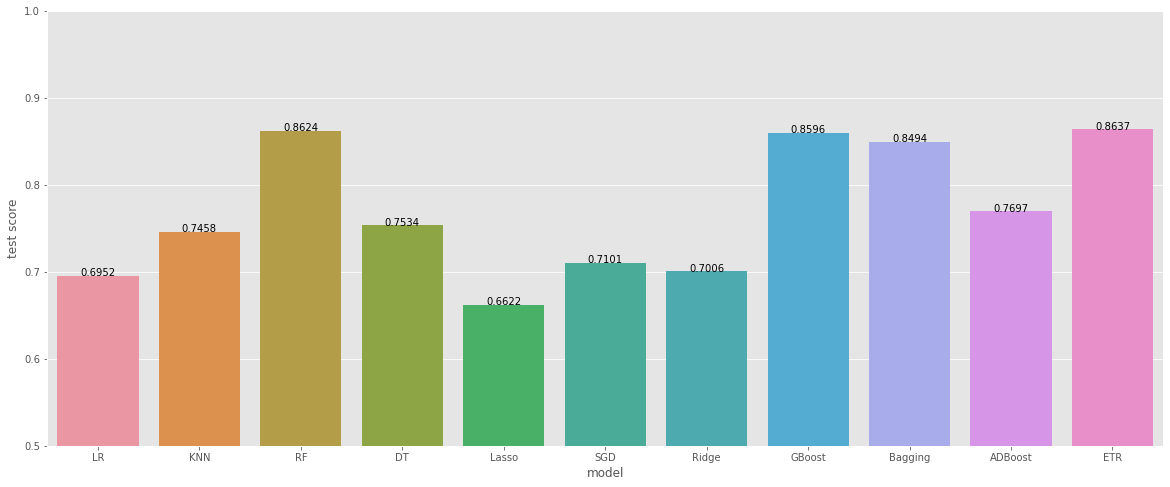

In [21]:
plt.figure(figsize = (20, 8))
bars = sns.barplot(x='model',y='test score',data=mod)
for i,score in enumerate(mod['test score']):
    bars.text(i,score,round(score,4),ha='center')
plt.ylim(0.50, 1)
plt.show()

The Extra Trees Regressor is the most accurate but Random Forest, Gradient Boost, and Bagging are also intriguing. However, to further simplify the model, it may be useful to remove some variables such as water & cement since the w/c ratio is already included. Also since coarse aggregate has a very low correlation with strength (-0.06) it is probably okay to try and remove this variable as well.

In [22]:
#remove coarse aggregate from the variables 
#variables2 = variables.drop(columns='coarse agg')
variables2 = variables.drop(columns=['water', 'cement','coarse agg'])

scaledVars2 = sc.fit_transform(variables2)
scaledVars2 = pd.DataFrame(scaledVars2,columns=variables2.columns)

In [23]:
#split the data into an 70/30 train/test set
trainVars2,testVars2,trainStrength2,testStrength2=train_test_split(scaledVars2,strength,test_size=.30,random_state=0)

trainAccuracy2=[]
testAccuracy2=[]
for model in models:
    #fit the model to the data
    model.fit(trainVars2,trainStrength2)
    #get the r-squared score
    trainAccuracy2.append(model.score(trainVars2,trainStrength2))
    testAccuracy2.append(model.score(testVars2,testStrength2))
    
mod2=pd.DataFrame([modelNames,trainAccuracy2,testAccuracy2]).T
mod2.columns=['model','train score','test score']

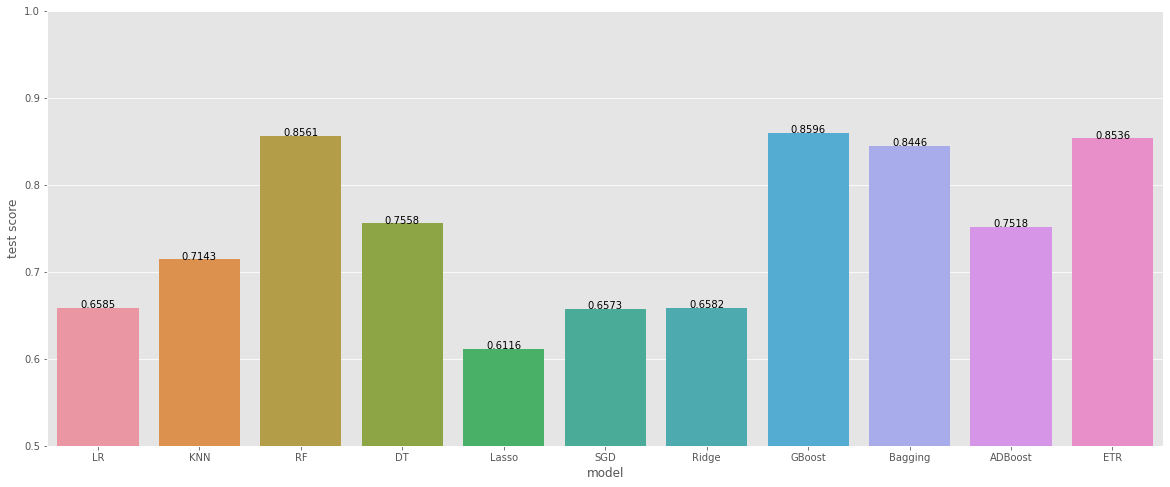

In [24]:
plt.figure(figsize = (20, 8))
bars2 = sns.barplot(x='model',y='test score',data=mod2)
for i,score in enumerate(mod2['test score']):
    bars2.text(i,score,round(score,4),ha='center')
plt.ylim(0.50, 1)
plt.show()

After removing the water, cement, and coarse aggregate variables, the test score accuracy does not change significantly (less than 1%) so it is better to use this simpler model. Since RF and GBoost performed the best in this quick test, I will use a grid search and cross validation to validate results and optimize parametrs.

# Model Optimization and Validation

In [25]:
# hyper parameter tuning of gradient boost regressor 
grid_params = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'n_estimators': [1,2,5,10,20,50,100],
    'criterion' : ['friedman_mse', 'mse', 'mae'],
    'min_samples_split' : [1,2,3,4,5],
    'min_samples_leaf' : [1,2,3,4,5]
}

grid_search = GridSearchCV(gboost, grid_params, cv = 5, n_jobs = -1)
grid_search.fit(trainVars2, trainStrength2)

# best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Parameters: {'criterion': 'friedman_mse', 'loss': 'huber', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 100}
Best Score: 0.8421711792906391


In [26]:
# hyper parameter tuning of random forest regressor 
grid_params = {
    'n_estimators': [1,2,5,10,20,50,100],
    'max_depth' : [None,3,5,7,9,10,20],
    'min_samples_split' : [1,2,3,4,5],
    'min_samples_leaf' : [1,2,3,4,5]
}

grid_search = GridSearchCV(rf, grid_params, cv = 5, n_jobs = -1)
grid_search.fit(trainVars2, trainStrength2)

# best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}
Best Score: 0.8312056666435975


The Gradient Boost regressor has a higher accuracy of 84.2% so this model will be trained with those selected parameters from the grid search.

In [32]:
strengthPredictionModel = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', min_samples_leaf=4, min_samples_split=3, n_estimators=100)
strengthPredictionModel.fit(trainVars2, trainStrength2)
finalTestScore = model.score(testVars2,testStrength2)
print(f'Final Test Score: {finalTestScore}')

Final Test Score: 0.8535503548138041


r2:0.849738530281101
rmse:5.627307485079501


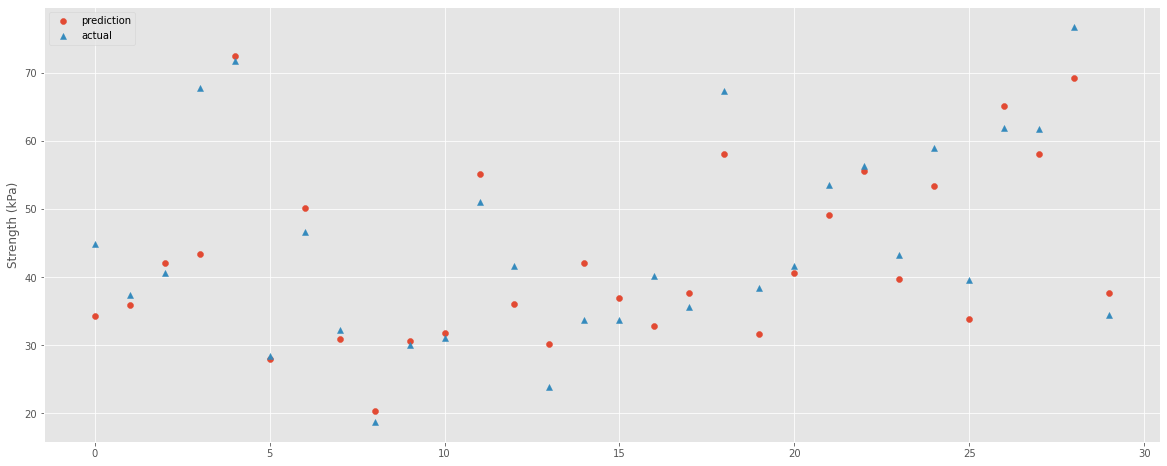

In [88]:
from numpy import arange
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
plt.figure(figsize = (20, 8))
actual = testStrength2
predictions = strengthPredictionModel.predict(testVars2)

rowsToPlot = 30
plt.scatter(arange(len(predictions[:rowsToPlot])),predictions[:rowsToPlot])
plt.scatter(arange(len(actual[:rowsToPlot])),actual[:rowsToPlot],marker='^')
plt.legend(['prediction','actual'])
plt.ylabel('Strength (kPa)')

r2 = r2_score(actual,predictions)
rmse = mean_squared_error(actual,predictions,squared=False)
print(f'r2:{r2}')
print(f'rmse:{rmse}')

The RMSE indicates that the average error in the prediction is about 5.6 MPa which is not bad. The final accuracy is 85%.

In [27]:
#from bokeh.io import reset_output
#reset_output()

In [ ]:
#import numpy as np
#from bokeh.io import curdoc, output_notebook, push_notebook
#from bokeh.layouts import column, row
#from bokeh.models import ColumnDataSource, Slider, LabelSet
#from bokeh.plotting import figure, show, output_file 
#from ipywidgets import interact
#output_notebook()

#TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

# create a Figure object
#p = figure(title='Strength Prediction',plot_width=500, plot_height=500, tools=TOOLS)
#p.text(0, 0, text='twenty',text_baseline='middle', text_align='center')
#p.grid.visible = False
#p.axis.visible = False

# add a Circle renderer to this figure
#r=1
#c = p.circle(0,0,fill_color='blue',radius=r,alpha=0.5)

#def callback(r):
    #p.circle(0,0,color='white',radius=1)
    #p.circle(0,0,radius=r,alpha=0.5)
    #push_notebook()

# display the figure
#show(p,notebook_handle=True)

#interact(callback,r=(0.1,1,0.1))